# Homework 3

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

## Problem 1

Let's explore hyperparameter optimization.  We'll do something relatively simple that's actually not far from what most people do to study the effect of hyperparameters on their model.  Let's revisit the neural network we implemented to learn the $\sin$ function in our `NeuralNetworks2` notebook.

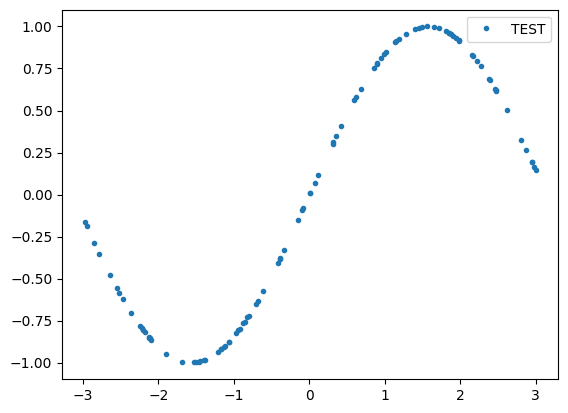

In [ ]:
torch.manual_seed(123)
x_train = 6 * torch.rand((1000, 1)) - 3
y_train = torch.sin(x_train)
x_test = 6 * torch.rand((100, 1)) - 3
y_test = torch.sin(x_test)
plt.plot(x_test.numpy(), y_test.numpy(), '.', label='TEST')
plt.legend();

Wrap the tensors into Dataset objects to simplify passing them around:

In [ ]:
xy_train = torch.utils.data.TensorDataset(x_train, y_train)
xy_test = torch.utils.data.TensorDataset(x_test, y_test)

Create (and save) the baseline model to use:

In [ ]:
torch.manual_seed(123)
baseline = torch.nn.Sequential(
    torch.nn.Linear(1, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 250),
    torch.nn.ReLU(),
    torch.nn.Linear(250, 1),
)
torch.save(baseline.state_dict(), 'baseline.pth')

Now, your job: implement the function below to build a train and test loop using hyperparameters specified as function arguments. Your code should produce a single scatter plot showing the TRAIN and TEST loss curves, similar to the ones we produced earlier.

([tensor(0.2683), tensor(0.1239), tensor(0.1460), tensor(0.1082), tensor(0.0459), tensor(0.0557), tensor(0.0366), tensor(0.0234), tensor(0.0198), tensor(0.0146), tensor(0.0137), tensor(0.0120), tensor(0.0106), tensor(0.0101), tensor(0.0083), tensor(0.0101), tensor(0.0070), tensor(0.0062), tensor(0.0058), tensor(0.0051), tensor(0.0054), tensor(0.0050), tensor(0.0050), tensor(0.0043), tensor(0.0030), tensor(0.0045), tensor(0.0026), tensor(0.0030), tensor(0.0024), tensor(0.0025), tensor(0.0030), tensor(0.0031), tensor(0.0020), tensor(0.0021), tensor(0.0021), tensor(0.0023), tensor(0.0018), tensor(0.0015), tensor(0.0014), tensor(0.0016), tensor(0.0016), tensor(0.0014), tensor(0.0012), tensor(0.0012), tensor(0.0012), tensor(0.0011), tensor(0.0012), tensor(0.0012), tensor(0.0009), tensor(0.0008), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0008), tensor(0.0006), tensor(0.0007), tensor(0.0006), tensor(0.0008), tensor(0.0006), tensor(0.0005), tensor(0.0005), tensor(0.0006), tensor

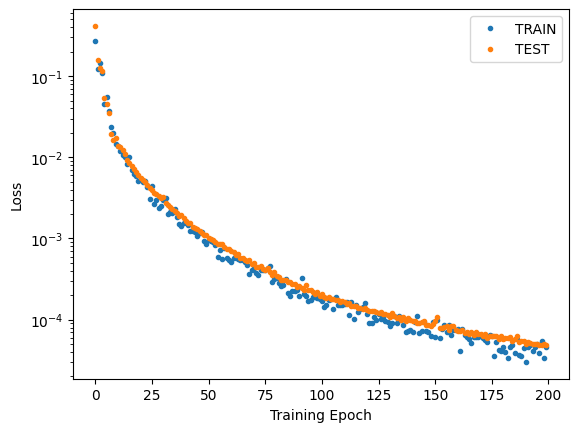

In [ ]:
def learn(train_data, test_data, model, loss_fn=torch.nn.MSELoss(), n_epochs=200,
          batch_size=200, learning_rate=0.1, momentum=0.9, make_plot=True):
    """Perform a train and test loop with specified hyperparameters.

    Uses SGD optimization and produces a scatter plot of TRAIN and TEST
    loss versus epoch on a log-linear scale.

    Parameters
    ----------
    train_data : torch.utils.data.Dataset
        Container for the training input and target tensors to use.
    test_data : torch.utils.data.Dataset
        Container for the test input and target tensors to use.
    model : torch.nn.Module
        Neural network model of the data whose parameters will be learned.
    loss_fn : callable
        Function of (y_out, y_tgt) that calculates the scalar loss to use.
        Must support backwards() method.
    n_epochs : int
        Number of epochs of training to perform.
    batch_size : int
        Size of each (randomly shuffled) minibatch to use.
    learning_rate : float
        Learning rate to use for the SGD optimizer.
    momentum : float
        Momentum to use for the SGD optimizer.

    Returns
    -------
    tuple
        Tuple (train, test) of arrays of loss values after each epoch for
        the TRAIN and TEST samples, respectively. Both lists should have
        length equal to n_epochs.
    """

    losses_train, losses_test = [], []
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    x_test, y_test = test_data.tensors

    # YOUR CODE HERE...  replace the next line with your solution

    net=baseline
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    #net.load_state_dict(torch.load('net.pth'))
    for epoch in range(n_epochs):
      net.train()
      """y_pred = net(x_train)
      loss = loss_fn(y_pred, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses_train.append(loss.data)
      net.eval()
      y_pred = net(x_test)"""
      for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      losses_train.append(loss.data)
      net.eval()
      y_pred = net(x_test)
      losses_test.append(loss_fn(y_pred, y_test).data)
    #raise NotImplementedError()

    if make_plot:
        plt.plot(losses_train, '.', label='TRAIN')
        plt.plot(losses_test, '.', label='TEST')
        plt.legend()
        plt.xlabel('Training Epoch')
        plt.ylabel('Loss')
        plt.yscale('log');
    return losses_train, losses_test
print(learn(xy_train, xy_test,baseline))

Test your code with the default hyperparameters using:

tensor(0.0006)
tensor(0.0007)


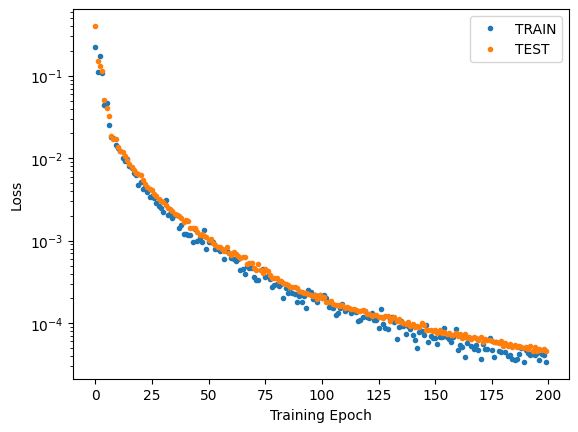

In [ ]:
# A correct solution should pass these tests.
torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
train, test = learn(xy_train, xy_test, baseline)
print(train[60])
print(test[60])
assert train[0] > 0.1 and test[0] > 0.1
assert train[60] < 1e-3 and test[60] < 1e-3
assert train[-1] < 1e-4 and test[-1] < 1e-4

Run the cell below to establish the same initial state (seed and model parameters) and repeat this learning loop with the optimizer momentum set to zero, to show its effect on the loss curves: large synchronized oscillations in both the TRAIN and TEST data.

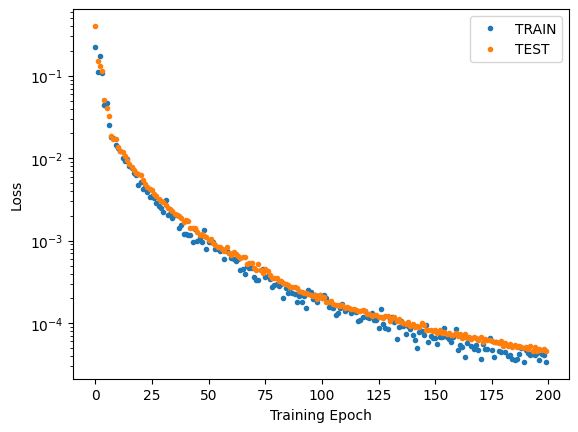

In [ ]:
torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
learn(xy_train, xy_test, baseline, momentum=0);

Now we'll scan different values of the batch size, learning rate, and momentum to find good configurations.  In general it's best to do this by sampling random values of each parameter on any given trial, but for ease of interpretation we'll do it in 1-dimension for a few different sets of configurations.

Make plots showing the loss curves for the training data for each of the following sets of configurations:
* Learning rate = 0.06, batch size=51, for momenta between 0.79 and 1.0 in steps of 0.05
* Momentum=0.9, batch size=51, for learning rates between 0.01 and 0.22 in steps of 0.05
* Learning rate = 0.1, momentum=0.9, between 1 and the size of the training set, in steps of 100

Some notes:
* Make sure to reset the random seed and reload the network before each call to the `learn` function!

([tensor(3.6613e-05), tensor(3.1460e-05), tensor(4.6847e-05), tensor(3.9743e-05), tensor(4.7386e-05), tensor(5.8347e-05), tensor(2.8244e-05), tensor(1.2701e-05), tensor(2.6616e-05), tensor(1.1926e-05), tensor(1.7406e-05), tensor(6.6532e-05), tensor(1.6192e-05), tensor(2.9066e-05), tensor(6.9466e-05), tensor(3.6955e-05), tensor(1.0846e-05), tensor(1.3806e-05), tensor(1.7114e-05), tensor(1.3918e-05), tensor(1.8200e-05), tensor(1.7060e-05), tensor(1.9843e-05), tensor(1.6113e-05), tensor(2.3400e-05), tensor(1.6371e-05), tensor(2.8505e-05), tensor(1.6627e-05), tensor(1.3458e-05), tensor(2.1948e-05), tensor(8.8950e-06), tensor(3.3614e-05), tensor(4.4997e-06), tensor(1.3980e-05), tensor(1.9913e-05), tensor(1.5409e-05), tensor(4.3377e-06), tensor(1.7173e-05), tensor(4.0447e-06), tensor(7.1275e-06), tensor(2.0104e-05), tensor(1.8195e-05), tensor(1.4119e-05), tensor(1.1185e-05), tensor(1.2739e-05), tensor(1.0679e-05), tensor(1.0945e-05), tensor(1.2462e-05), tensor(1.1993e-05), tensor(5.9135e-06)

Text(0.5, 1.0, 'Changing Momenta')

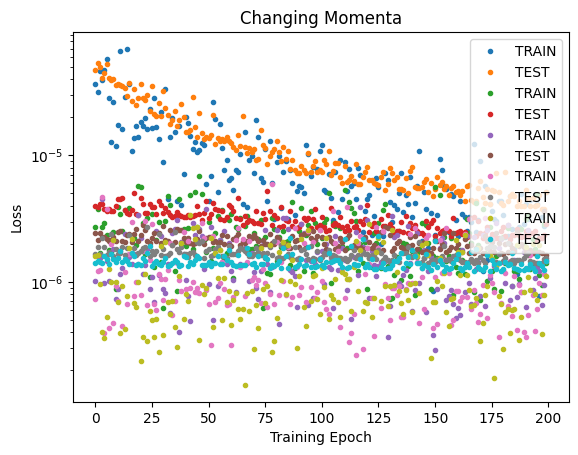

In [ ]:
#print(learn(xy_train, xy_test,baseline, learning_rate=0.06, momentum=0.8, batch_size=51))



for i in np.arange(0.79, 1, 0.05):
  print(learn(xy_train, xy_test,baseline, learning_rate=0.06, momentum=i, batch_size=51))
  print(i)
plt.title("Changing Momenta")

0.01
([tensor(3.8040e-07), tensor(1.4354e-06), tensor(1.3966e-06), tensor(7.9130e-07), tensor(6.4183e-07), tensor(5.0052e-07), tensor(8.9028e-07), tensor(4.2178e-07), tensor(1.2027e-06), tensor(3.7016e-07), tensor(1.9939e-06), tensor(4.1653e-07), tensor(9.8070e-07), tensor(7.3665e-07), tensor(7.6196e-08), tensor(4.5640e-07), tensor(9.7790e-07), tensor(1.0032e-06), tensor(4.1097e-07), tensor(3.8077e-07), tensor(4.0130e-07), tensor(2.1785e-06), tensor(6.5124e-07), tensor(1.1540e-06), tensor(4.4912e-07), tensor(8.9649e-07), tensor(8.5254e-07), tensor(6.6820e-07), tensor(9.6085e-07), tensor(3.2279e-07), tensor(1.3273e-06), tensor(1.4058e-06), tensor(3.2727e-07), tensor(1.2488e-06), tensor(4.1091e-07), tensor(1.0588e-06), tensor(8.5794e-07), tensor(1.3179e-06), tensor(1.4481e-06), tensor(1.6454e-06), tensor(1.0817e-06), tensor(4.3862e-07), tensor(1.8547e-06), tensor(1.0317e-06), tensor(7.7916e-07), tensor(1.1981e-06), tensor(7.8282e-07), tensor(1.5618e-06), tensor(3.7620e-07), tensor(5.5398

Text(0.5, 1.0, 'Changing Learning Rate')

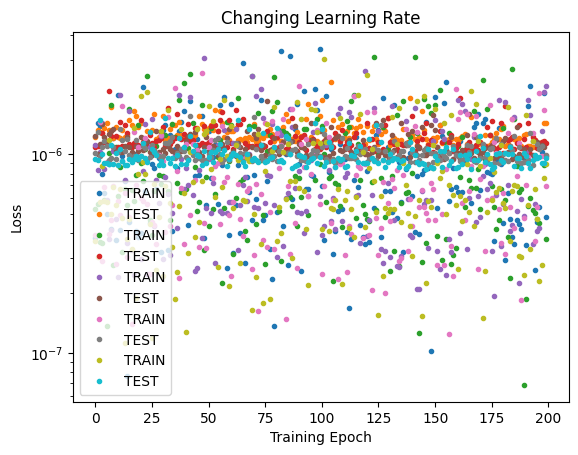

In [ ]:
# checking the learning rate
for i in np.arange(0.01, 0.22, 0.05):
  print(i)
  print(learn(xy_train, xy_test,baseline, learning_rate=i, momentum=0.9, batch_size=51))
plt.title("Changing Learning Rate")

[  1 101 201 301 401 501 601 701 801 901]
100
([tensor(3.6542e-07), tensor(3.1388e-07), tensor(8.0127e-07), tensor(6.3504e-07), tensor(1.1792e-06), tensor(3.6055e-07), tensor(9.0118e-07), tensor(1.0737e-06), tensor(5.5620e-07), tensor(7.0685e-07), tensor(4.1576e-07), tensor(2.6306e-07), tensor(5.6806e-07), tensor(4.1845e-07), tensor(6.8125e-07), tensor(7.3253e-07), tensor(7.5535e-07), tensor(9.8499e-07), tensor(8.3059e-07), tensor(4.1640e-07), tensor(1.0507e-06), tensor(7.6276e-07), tensor(5.1348e-07), tensor(1.1092e-06), tensor(1.1724e-06), tensor(6.0999e-07), tensor(3.6270e-07), tensor(7.2796e-07), tensor(5.0769e-07), tensor(1.0377e-06), tensor(6.2249e-07), tensor(1.1360e-06), tensor(3.7764e-07), tensor(9.4394e-07), tensor(6.2256e-07), tensor(6.4150e-07), tensor(2.2073e-07), tensor(8.8779e-07), tensor(3.3916e-07), tensor(3.4258e-07), tensor(1.0545e-06), tensor(7.4482e-07), tensor(8.8163e-07), tensor(5.2829e-07), tensor(5.9824e-07), tensor(8.6305e-07), tensor(7.4285e-07), tensor(4.328

Text(0.5, 1.0, 'Changing Batch Size')

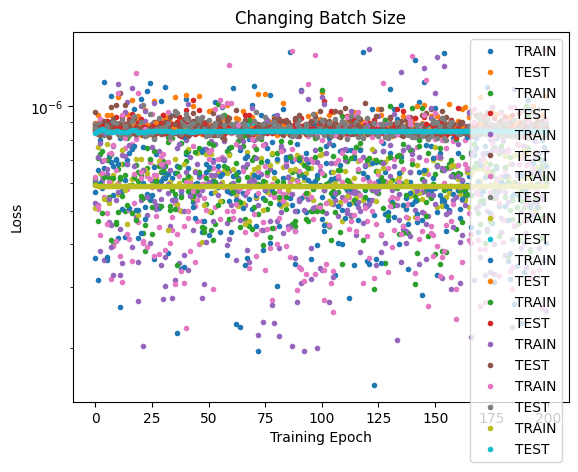

In [ ]:
# checking the batch size
#print(len(xy_train))
batching=np.arange(1,len(xy_train), 100, dtype=int)

keaton_batch=np.array([100,200,300,400,500,600,700,800,900,1000])
print(batching)


for i in keaton_batch:
  print(i)
  print(learn(xy_train, xy_test,baseline, learning_rate=0.06, momentum=0.9, batch_size=int(i)))
##print(learn(xy_train, xy_test,baseline, learning_rate=0.06, momentum=0.9, batch_size= [x for x in range(1,1000,100)]))
plt.title("Changing Batch Size")


## Problem 2

Let's play around with convolutional kernels and see if we can make some simple filters to apply to real images.  We'll use the `torchvision` package to transform common image formats:

In [ ]:
from PIL import Image
import torchvision

The pytorch `Conv2D` function that we used to implement some convolutional layers is a high-level function call, and manages the kernel weights internally.

In [ ]:
# With square kernels and equal stride
m = torch.nn.Conv2d(16, 33, 3, stride=2)

# non-square kernels and unequal stride and with padding
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))

# non-square kernels and unequal stride and with padding and dilation
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))

# generate some random input:
input = torch.randn(20, 16, 50, 100)

# compute the output:
output = m(input)

We can use the lower-level function `torch.nn.functional.conv2d` to manipulate kernels and tensors directly.

Let's do something simple: let's define a 1-layer 5x5 matrix and convolve it with a 3x3 kernel to produce a 3x3 output feature map.  We'll make the kernel super-simple, the equivalent of an identity matrix for convolutions.

In [ ]:
channels = 1
h, w = 5, 5
x = torch.randn(1, channels, h, w)
print(x)
weights = torch.tensor([[0., 0., 0.],
                        [0., 1., 0.],
                        [0., 0., 0.]])
weights = weights.view(1, 1, 3, 3)

output = torch.nn.functional.conv2d(x, weights)
print(output)

tensor([[[[ 1.9603, -0.3451, -0.6001,  0.6683,  1.0927],
          [ 0.9504,  0.4767,  0.4165,  1.8568, -0.1780],
          [ 1.0457, -2.8479,  0.4152,  2.0530, -1.4136],
          [ 0.7555,  0.0192, -0.0719,  1.5046,  0.1570],
          [ 0.4186,  1.5079,  0.4076, -0.5289,  0.0535]]]])
tensor([[[[ 0.4767,  0.4165,  1.8568],
          [-2.8479,  0.4152,  2.0530],
          [ 0.0192, -0.0719,  1.5046]]]])


If we add in some padding, then we can make the output tensor the same size as the input:

In [ ]:
output = torch.nn.functional.conv2d(x, weights,padding=1)
print(output)

tensor([[[[ 1.9603, -0.3451, -0.6001,  0.6683,  1.0927],
          [ 0.9504,  0.4767,  0.4165,  1.8568, -0.1780],
          [ 1.0457, -2.8479,  0.4152,  2.0530, -1.4136],
          [ 0.7555,  0.0192, -0.0719,  1.5046,  0.1570],
          [ 0.4186,  1.5079,  0.4076, -0.5289,  0.0535]]]])


Of course it's possible to do this for more than just one channel, but that gets a bit tricky, so I'll leave that for you to play with if you want!

For now let's just try to do something simple with a one-channel image:

In [ ]:
import urllib.request
urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/banana-slug-misty-morehead.jpg", "banana_slug.jpg")

('banana_slug.jpg', <http.client.HTTPMessage at 0x7effcbb62e60>)

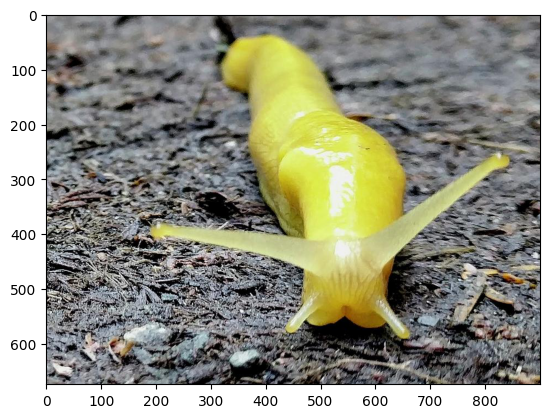

In [ ]:
img = Image.open("banana_slug.jpg")
plt.imshow(img)

We can turn this into a numpy array relatively easily:

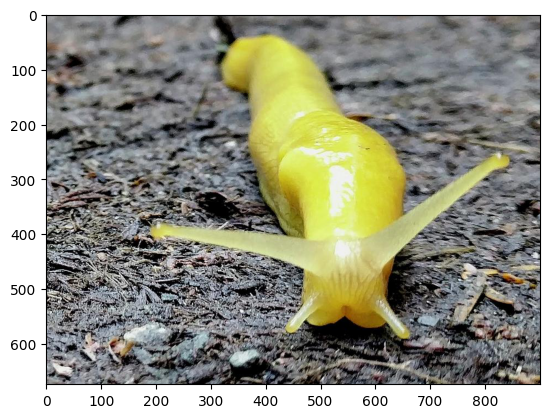

In [ ]:
npimg=np.asarray(img)
plt.imshow(npimg)

Or we can use `torchvision` to turn it into a pytorch tensor, and then check that the tensor gives us back the image:

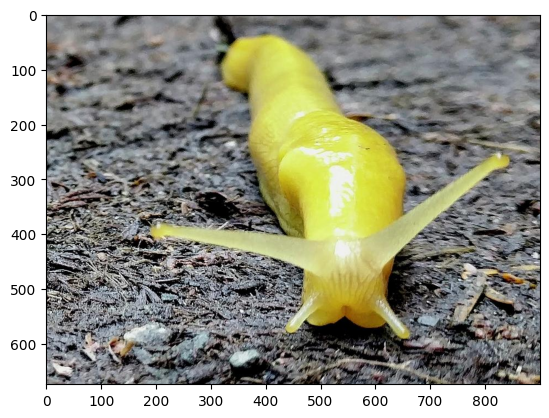

In [ ]:
imgtensor=torchvision.io.read_image("banana_slug.jpg")
plt.imshow(torchvision.transforms.functional.to_pil_image(imgtensor))

Let's make this a grayscale image so we only need to deal with a single channel:

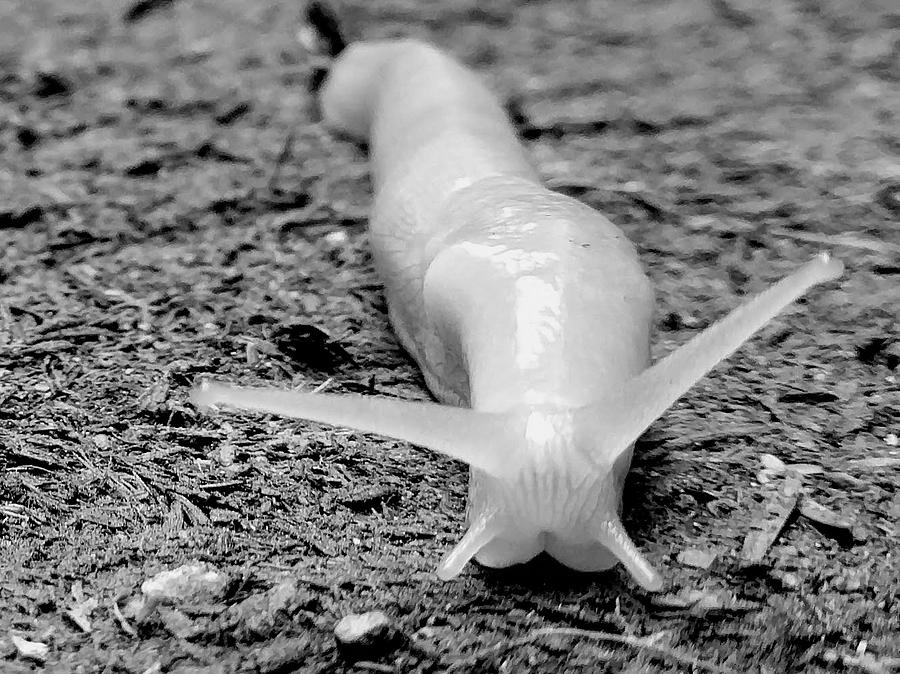

In [ ]:
grayscaleimage=torchvision.transforms.Grayscale()(img)
grayscaleimage.show()

Note that if we try to show this image using `plt.imshow` it will try to color it in for us:

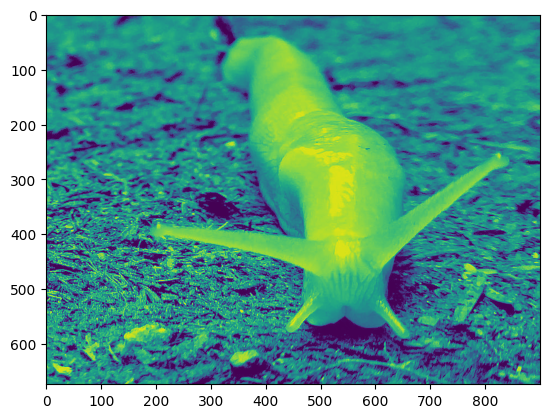

In [ ]:
plt.imshow(grayscaleimage)

So force it into grayscale:

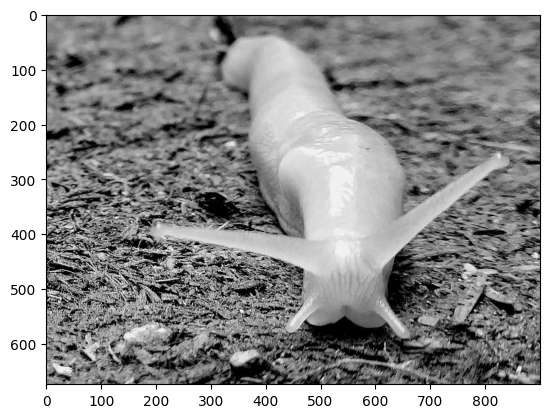

In [ ]:
plt.imshow(grayscaleimage,cmap='gray')

We can make this into a tensor for processing:

In [ ]:
grayscaleimagetensor=torchvision.transforms.functional.to_tensor(grayscaleimage)

Now, your job:
* implement a 3x3 kernel that shifts every pixel one step to the right
* take the difference between the resulting feature map and the original image
* display the resulting image

grayscale before: tensor([[[0.5725, 0.5725, 0.5765,  ..., 0.5020, 0.5020, 0.5020],
         [0.6000, 0.6039, 0.6078,  ..., 0.4980, 0.4980, 0.4980],
         [0.6000, 0.6000, 0.6039,  ..., 0.5020, 0.5020, 0.5020],
         ...,
         [0.5922, 0.5725, 0.4627,  ..., 0.0157, 0.0118, 0.0275],
         [0.5882, 0.5765, 0.5451,  ..., 0.1294, 0.1843, 0.2157],
         [0.5843, 0.5961, 0.6000,  ..., 0.3373, 0.3882, 0.4235]]])
after: tensor([[[0.5725, 0.5765, 0.5765,  ..., 0.5020, 0.5020, 0.0000],
         [0.6039, 0.6078, 0.6078,  ..., 0.4980, 0.4980, 0.0000],
         [0.6000, 0.6039, 0.6078,  ..., 0.5020, 0.5020, 0.0000],
         ...,
         [0.5725, 0.4627, 0.4118,  ..., 0.0118, 0.0275, 0.0000],
         [0.5765, 0.5451, 0.4941,  ..., 0.1843, 0.2157, 0.0000],
         [0.5961, 0.6000, 0.5765,  ..., 0.3882, 0.4235, 0.0000]]])


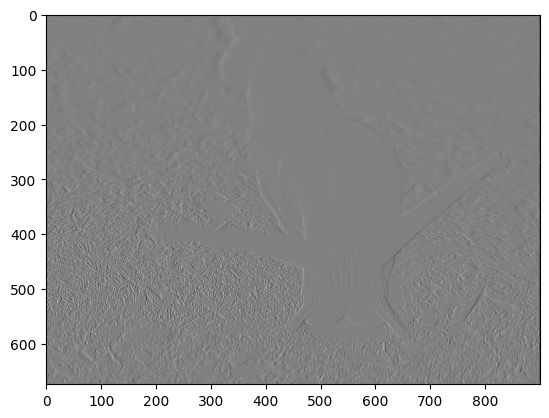

In [ ]:
# Your code here
print('grayscale before:',grayscaleimagetensor)
def imageshift(input):
  imageclone=input.clone()

weights = torch.tensor([[0., 0., 0.],
                        [0., 0., 1.],
                        [0., 0., 0.]])
weights = weights.view(1, 1, 3, 3)

output = torch.nn.functional.conv2d(grayscaleimagetensor, weights, padding=1)
final=output-grayscaleimagetensor
print('after:', output)
plt.imshow(final.numpy()[0], cmap='gray')


## Problem 3

This is the problem where you should explore the input dataset that you'll use for your final project.

I'll do this for a mock dataset, but you should go through a similar exercise with your dataset.

I'm importing data that's been stored in the HDF5 format, using the [h5py](https://docs.h5py.org/en/stable/) python package:

In [ ]:
import h5py

If your data are stored in a different format, then certainly some of the details below will have to change, that's OK!  There are lots of ways to read in CSV files and more complicated file formats into python data structures.

If you're using ROOT files (common in high-energy physics), there are also lots of ways to get information from those files into python lists.  If you want to convert a ROOT file into HDF5, you can use [this script](https://github.com/scipp-atlas/mario-mapyde/blob/main/scripts/root2hdf5.py).

In [ ]:
signalfile='lowlevelAna_stops.hf5'
urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/%s" % signalfile, signalfile)

backgrfile='lowlevelAna_ttbar.hf5'
urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/%s" % backgrfile, backgrfile)

('lowlevelAna_ttbar.hf5', <http.client.HTTPMessage at 0x7effcaa9ef20>)

Let's inspect the contents of the HDF5 file just to get a sense for what's there:

In [ ]:
with h5py.File(signalfile, 'r') as hdf5file:
    print("Here are the keys in this file")
    print(hdf5file.keys())
    print("\n")

    # let's access the first key by its index:
    group=hdf5file[list(hdf5file.keys())[0]]
    print("What type does this key have?")
    print(type(group))
    print("It's a group, so we'll need to look inside of the group to find the dataset")
    print(group.keys())
    data=group["lowleveltree"]
    print("\n")

    print("These are the fields (features) of the dataset:")
    print(data.dtype.names)
    print("\n")

    print("Here are the contents of the first event:")
    print(data[0])
    print("\n")

    print("This is the number of jets (numjet) in all events: ")
    print(data["numjet"])
    print("\n")

Here are the keys in this file
<KeysViewHDF5 ['allev']>


What type does this key have?
<class 'h5py._hl.group.Group'>
It's a group, so we'll need to look inside of the group to find the dataset
<KeysViewHDF5 ['lowleveltree']>


These are the fields (features) of the dataset:
('numlepton', 'numjet', 'numbtagjet', 'met', 'metphi', 'weight', 'lepton1pT', 'lepton1eta', 'lepton1phi', 'lepton1mT', 'lepton1minjetdr', 'lepton2pT', 'lepton2eta', 'lepton2phi', 'lepton2mT', 'lepton2minjetdr', 'lepton3pT', 'lepton3eta', 'lepton3phi', 'lepton3mT', 'lepton3minjetdr', 'jet1pT', 'jet1eta', 'jet1phi', 'jet1b', 'jet2pT', 'jet2eta', 'jet2phi', 'jet2b', 'jet3pT', 'jet3eta', 'jet3phi', 'jet3b', 'jet4pT', 'jet4eta', 'jet4phi', 'jet4b', 'jet5pT', 'jet5eta', 'jet5phi', 'jet5b', 'jet6pT', 'jet6eta', 'jet6phi', 'jet6b', 'jet7pT', 'jet7eta', 'jet7phi', 'jet7b', 'jet8pT', 'jet8eta', 'jet8phi', 'jet8b', 'jet9pT', 'jet9eta', 'jet9phi', 'jet9b', 'jet10pT', 'jet10eta', 'jet10phi', 'jet10b', 'jet11pT', 'jet11eta', 'j

Now that we know the format, accessing the data is a bit easier...  let's restrict the list of fields (I'll call them 'branches') we read in:

In [ ]:
branches=("numjet","numlepton","numbtagjet",
          "met","metphi",
          "lepton1pT","lepton1eta","lepton1phi",
          "lepton2pT","lepton2eta","lepton2phi",
          "jet1pT", "jet1eta", "jet1phi","jet1b",
          "jet2pT", "jet2eta", "jet2phi","jet2b",
          "jet3pT", "jet3eta", "jet3phi","jet3b",
          "jet4pT", "jet4eta", "jet4phi","jet4b",
          "jet5pT", "jet5eta", "jet5phi","jet5b",
          "jet6pT", "jet6eta", "jet6phi","jet6b")

with h5py.File(signalfile, 'r') as hdf5file:
    data=hdf5file[list(hdf5file.keys())[0]]["lowleveltree"]
    num_signal_events=len(data["numjet"])
    alldata=data[branches]

with h5py.File(backgrfile,'r') as hdf5file:
    data=hdf5file[list(hdf5file.keys())[0]]["lowleveltree"]
    num_backgr_events=len(data["numjet"])
    alldata = np.concatenate((alldata,data[branches]))

We read in the data as fields with a custom format, which is useful for keeping track of what's what, but
let's store this as python lists instead

In [ ]:
Alldata=[[float(i) for i in j] for j in alldata]
print(Alldata[0])

[3.0, 1.0, 1.0, 288.4065856933594, -0.06142895296216011, -3.113394260406494, 0.0, 0.0, -9.0, 0.0, 0.0, 197.14732360839844, 1.1485222578048706, -2.092724561691284, 0.0, 185.49407958984375, 0.19658531248569489, 2.4949371814727783, 1.0, 108.71955108642578, 1.519853949546814, 0.9874062538146973, 0.0, -999.0, -9.0, -9.0, -9.0, -999.0, -9.0, -9.0, -9.0, -999.0, -9.0, -9.0, -9.0]


The `Alldata` variable now contains all of the data for both signal and background events.  Since this will be for a binary classification problem, we want to keep track of which event is which, so we'll construct a `y` list that has 0's and 1's corresponding to whether each event is background (0) or signal (1).

In [ ]:
y = np.concatenate((np.ones (num_signal_events),
                    np.zeros(num_backgr_events)))

Now we can split our full dataset into training and test samples.  However, remember that the data aren't randomized...  the first N events of `Alldata` are all signal events, and the rest of the events are background events.  So we need to shuffle the data first, then pull out training and test samples of a specific size.  The `scikit learn` toolkit has a handy function that does this for us:

In [ ]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(Alldata, y, test_size=1000, random_state=123)

We can look at the input features for our training dataset.  First let's make a map of the feature name to the feature data:

In [ ]:
X_train_before_scaling={}
for b in branches:
    X_train_before_scaling[b]=[event[branches.index(b)] for event in X_train]

Now plot the data for each feature

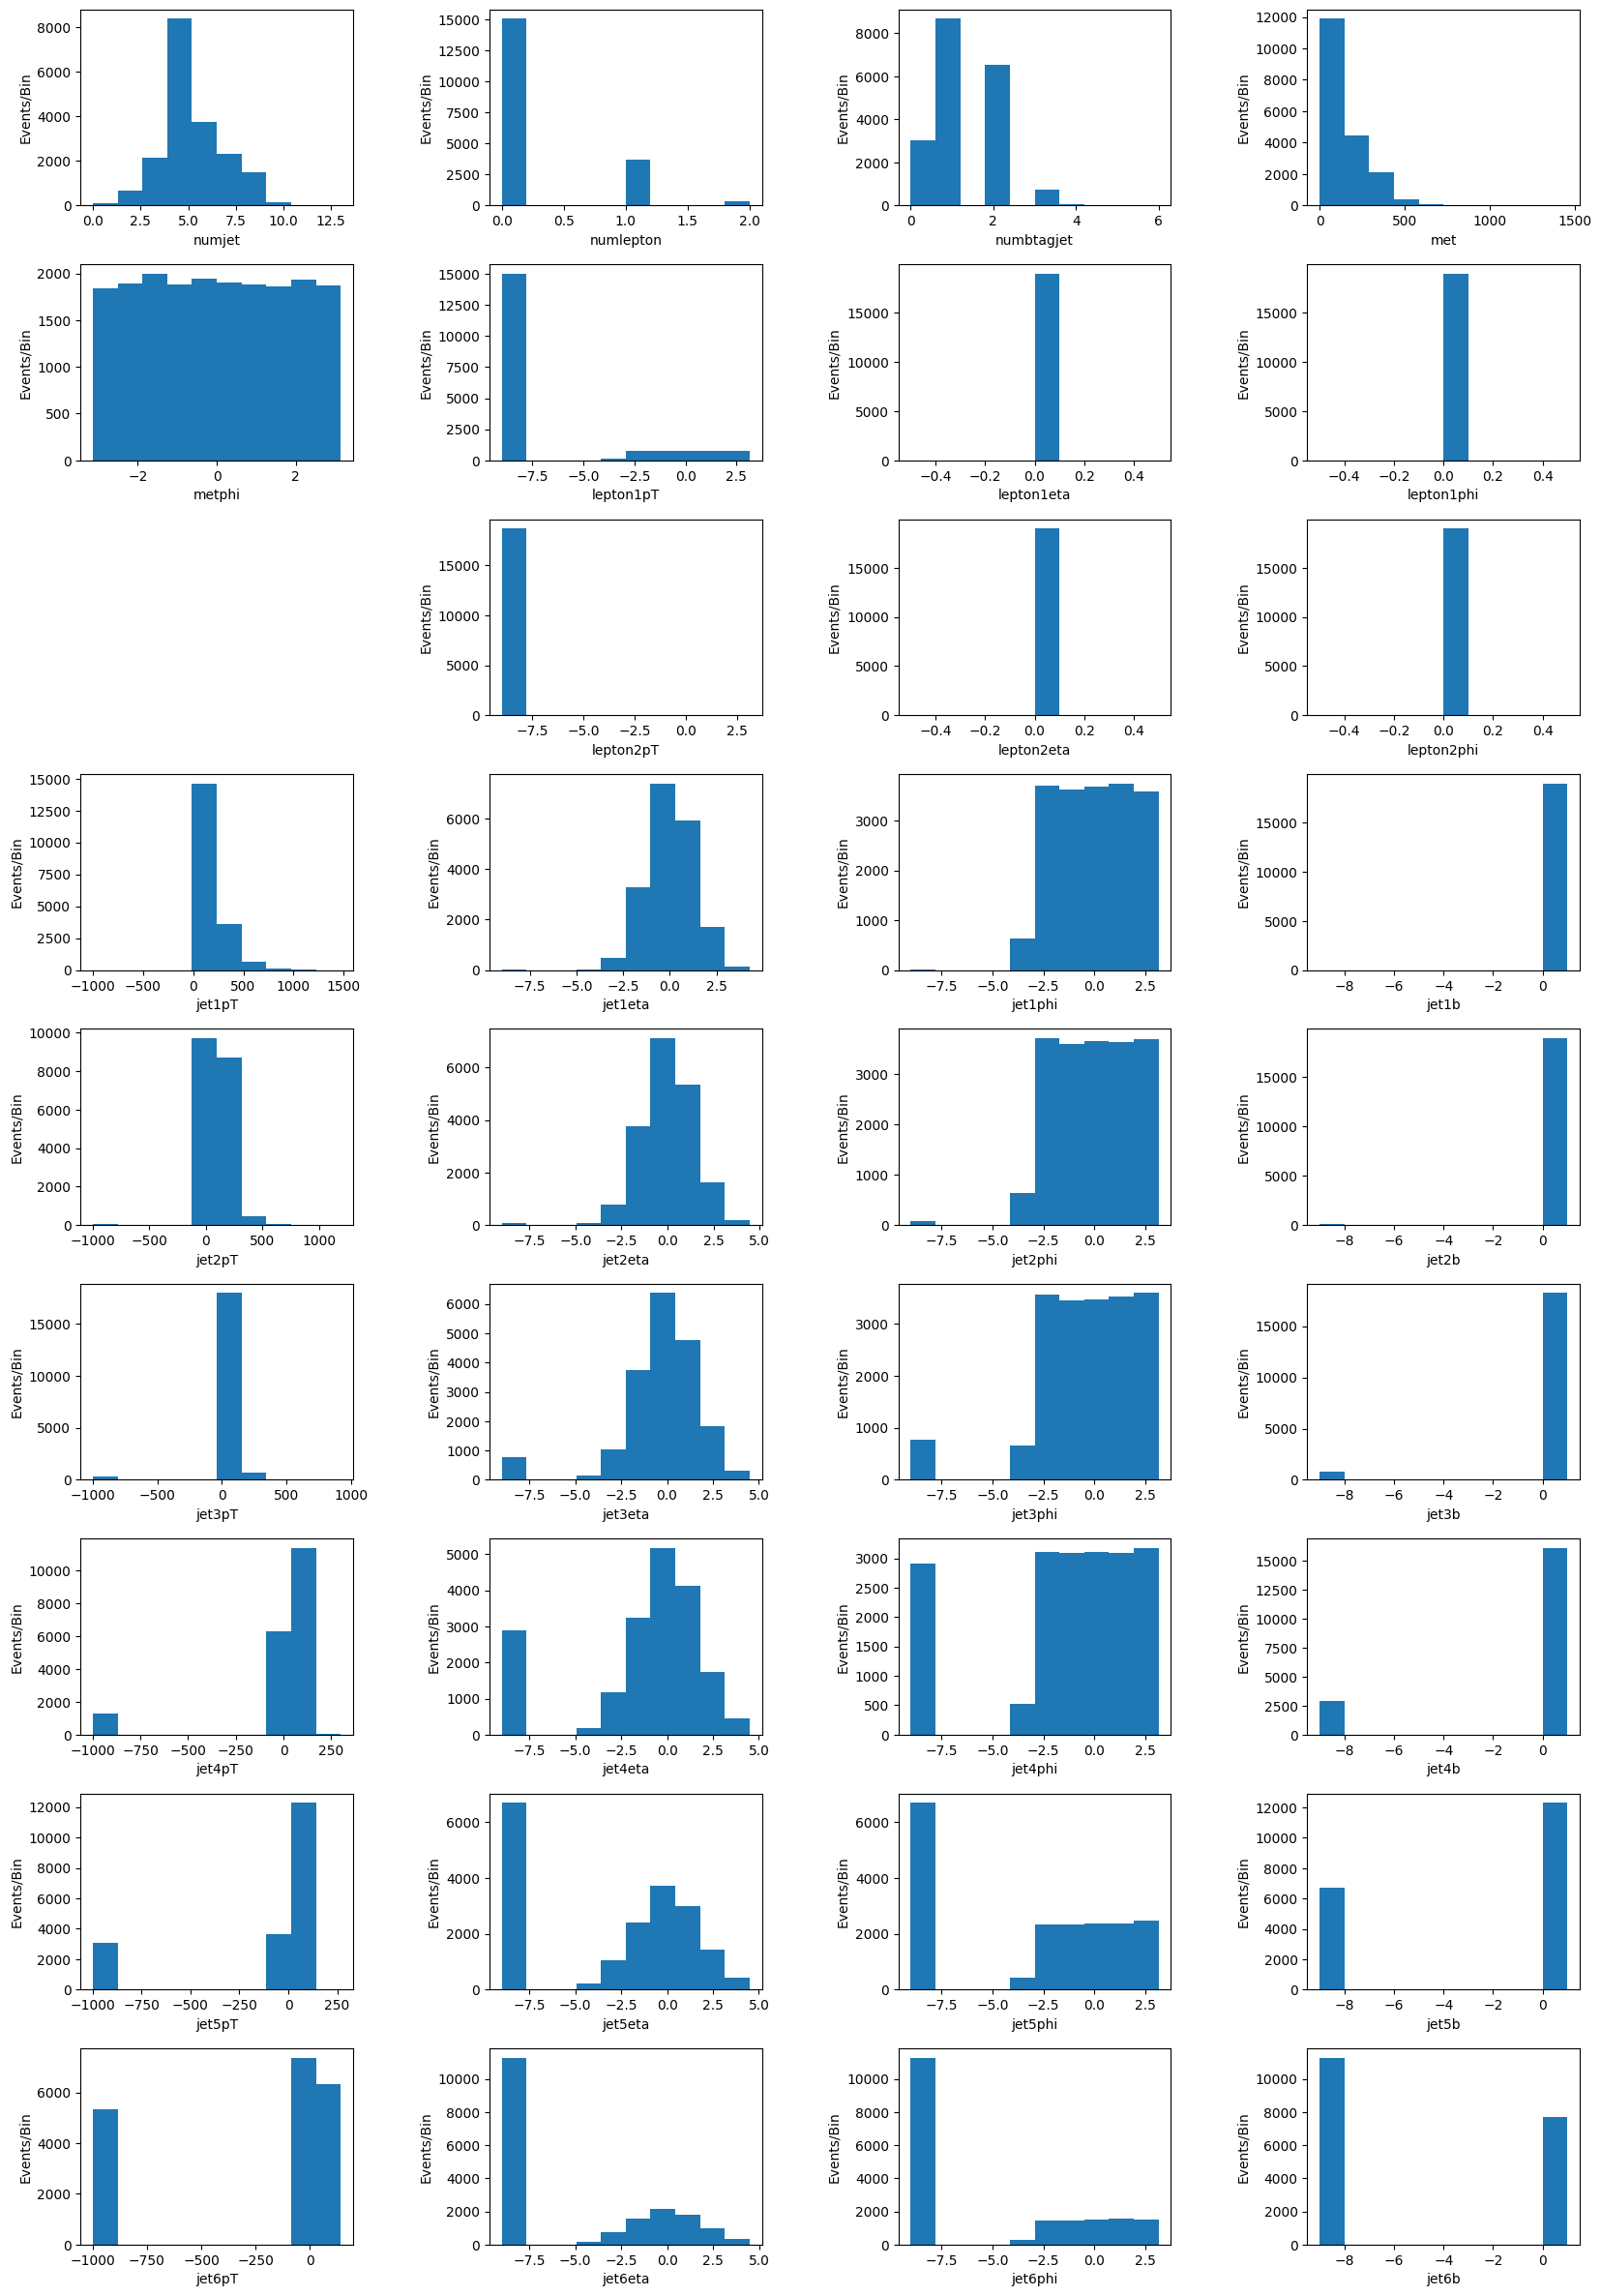

In [ ]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(branches)):
    ax=fig.add_subplot(9,4,1+b if b<8 else 2+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(X_train_before_scaling[branches[b]])
    ax.set_xlabel(branches[b])
    ax.set_ylabel("Events/Bin")

This looks good, but the inputs are all over the place!  Some are strictly positive, some have values in the 1's or 10's while others have values in the 1000's.  This broad range of inputs will likely confuse our network and cause some features to have inappropriate influence on the results.  So we should scale the events for each feature to give a distribution that has mean=0 and variance=1.  We can do this for each feature with the following mapping:

$$x \rightarrow z=\frac{x-\mu}{\sigma}$$

where $x$ is the original value, $z$ is the 'scaled' value, $\mu$ is the mean of all values of $x$, and $\sigma$ is the standard deviation of $x$.  This isn't hard to do by hand, but again `scikit learn` provides a handy way to do this:

In [ ]:
# now scale based on the training data:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


Let's make that handy map for the scaled data so we can look at the data by feature:

In [ ]:
X_train_after_scaling={}
for b in branches:
    X_train_after_scaling[b]=[event[branches.index(b)] for event in X_train]

Print some values just to see what happens to a typical variable:

In [ ]:
print(X_train_before_scaling["met"][:5])
print(X_train_after_scaling["met"][:5])

[147.20162963867188, 257.41204833984375, 277.15020751953125, 249.11927795410156, 182.775634765625]
[147.20162963867188, 257.41204833984375, 277.15020751953125, 249.11927795410156, 182.775634765625]


Now re-draw the features after they've been scaled to see what they look like:

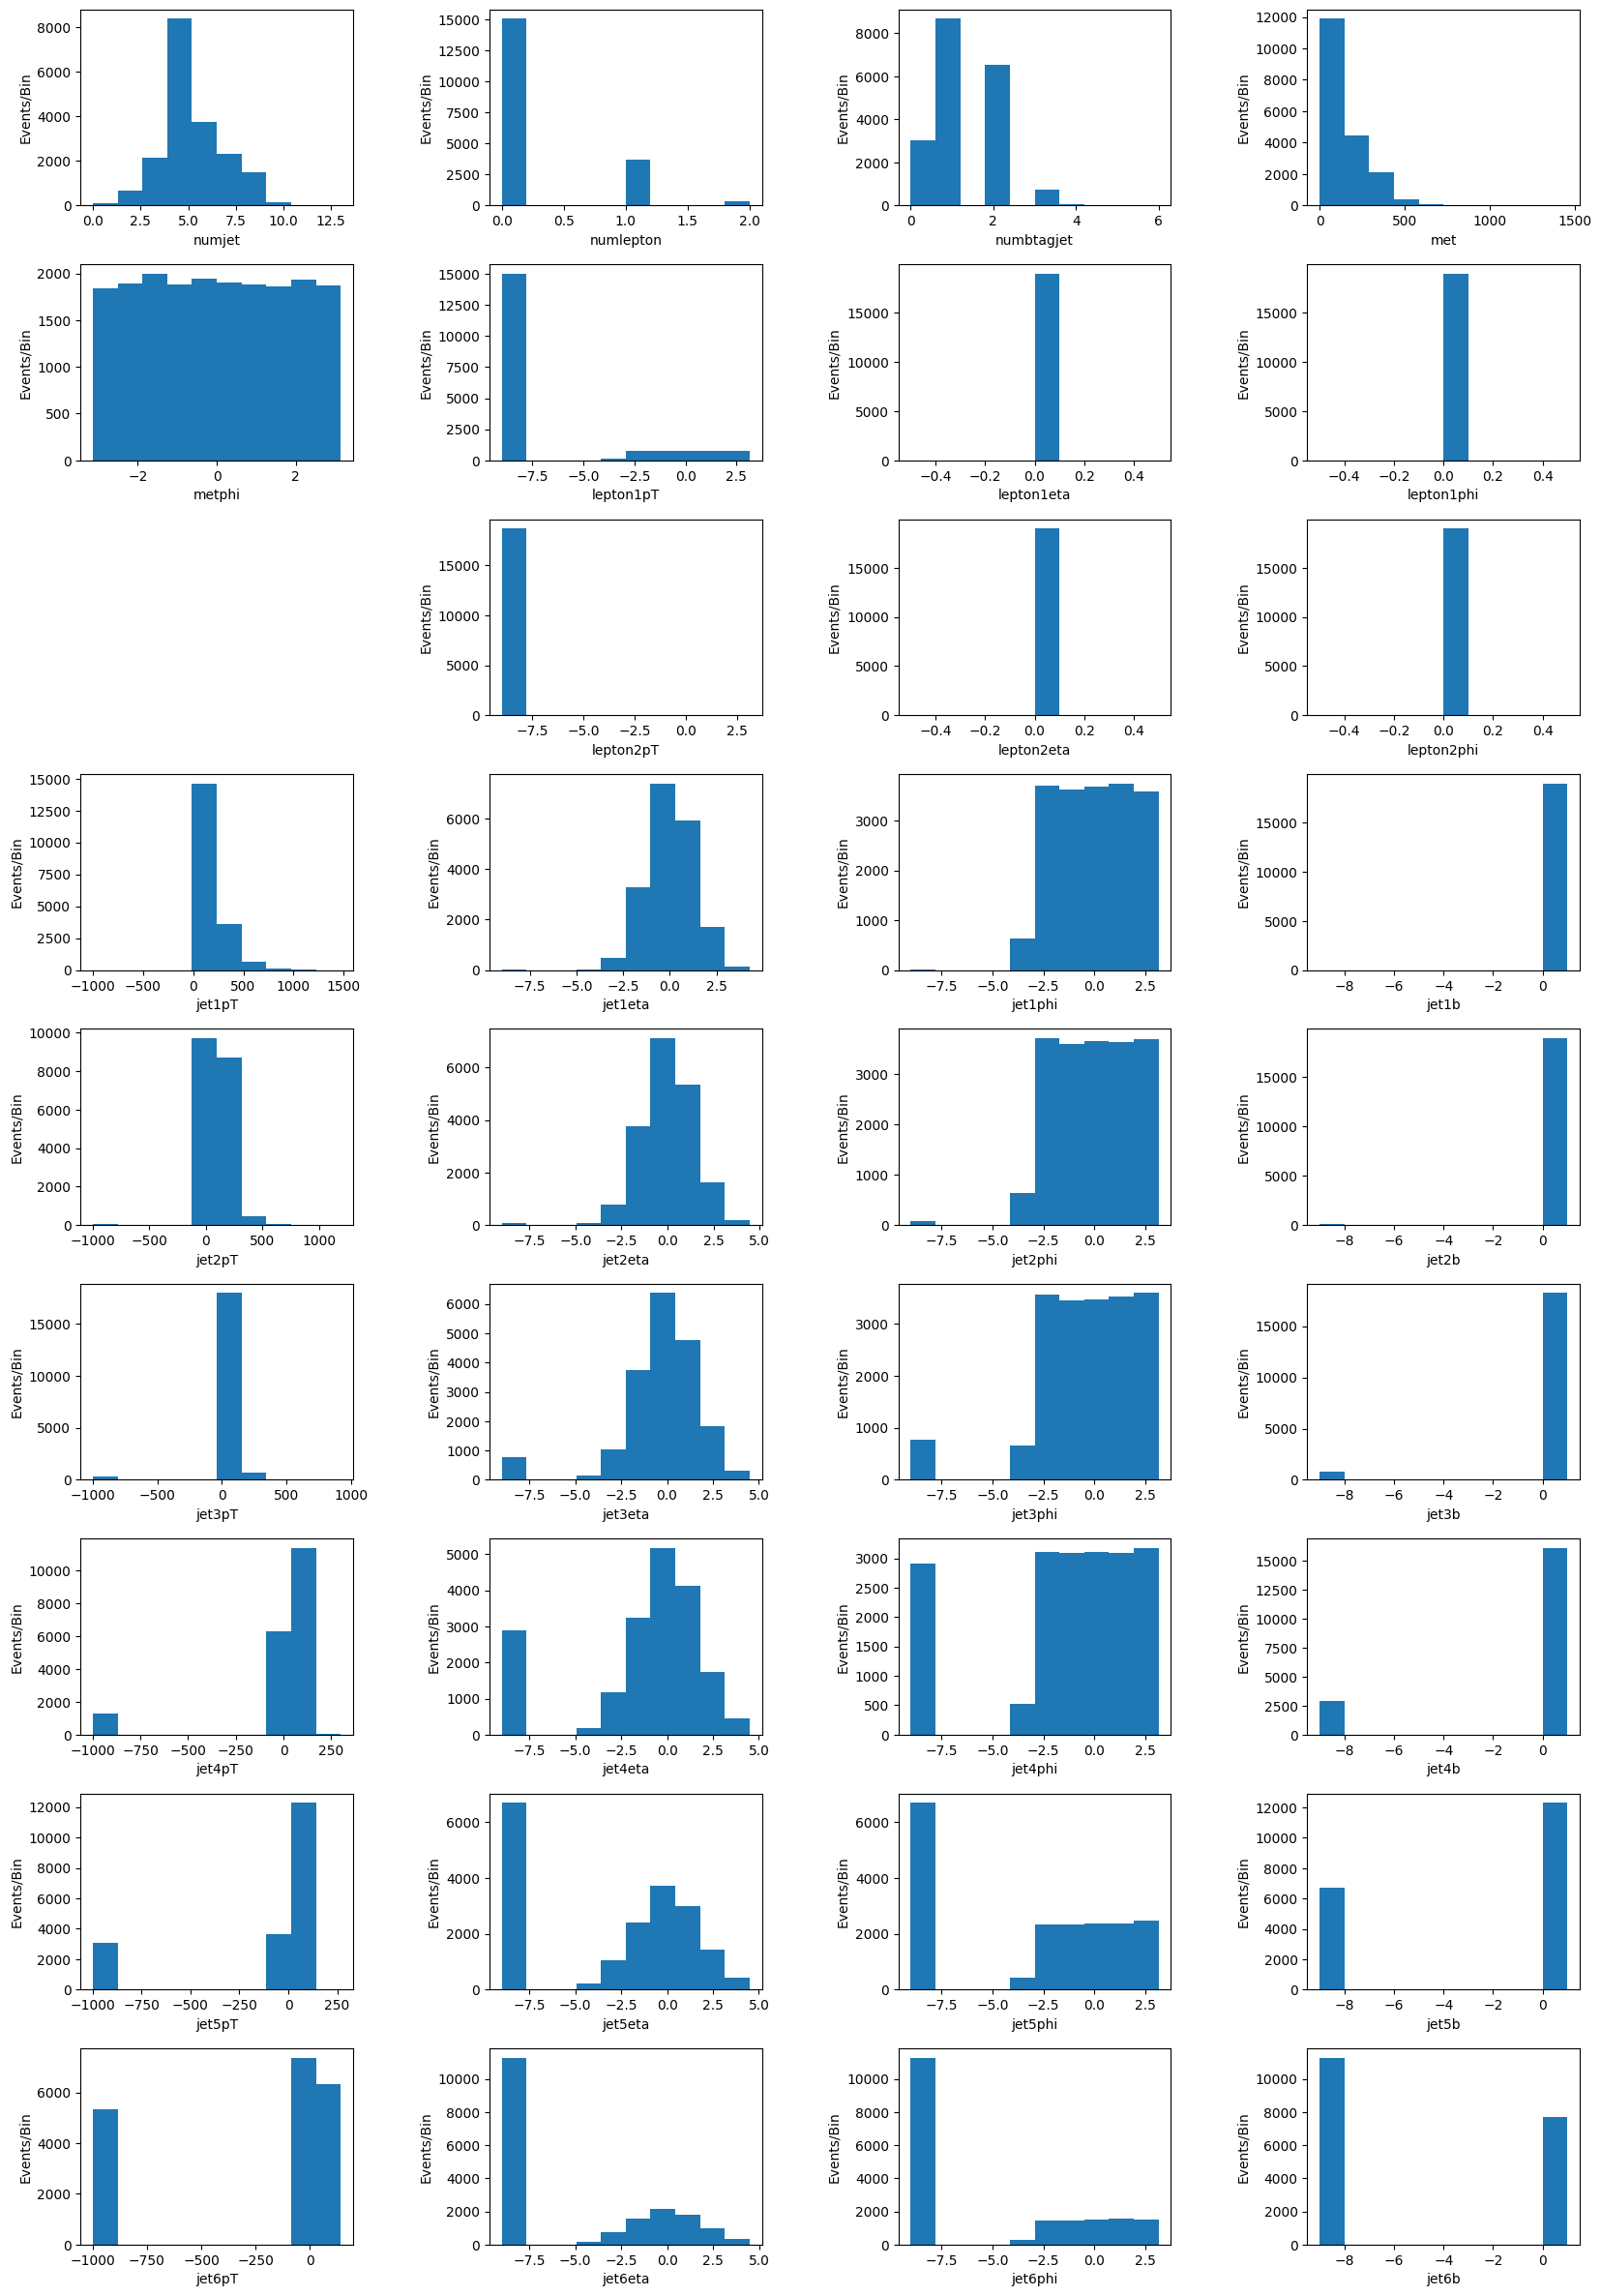

In [ ]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(branches)):
    ax=fig.add_subplot(9,4,1+b if b<8 else 2+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(X_train_after_scaling[branches[b]])
    ax.set_xlabel(branches[b])
    ax.set_ylabel("Events/Bin")


These look a lot better!

One last thing: we've scaled our training data, but not our test data.  Fortunately the `sc` object we created above will remember the transformation that we applied to the training data, so we can transform the test data in exactly the same way (note this is just `transform`, not `fit_transform`):

In [ ]:
X_test = sc.transform (X_test)

NotFittedError: ignored

Now do this for your data.  Try to get as far as you can.  Depending on the type of data you're analyzing, there may not be anywhere near as many plots to make as what I have above -- that's OK!  The important thing will be to identify what your features are, and make sure that the feature data are scaled appropriately.

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
#getting data from Drive and putting it into a dataframe
path = "/content/drive/MyDrive/Colab Notebooks/dielectron.csv"
df = pd.read_csv(path)


Here we have our data, found from here

These are what each variable means
Run: The run number of the event.

1.   Run: The run number of the event.
2.   Event: The event number.
3.  E1: The total energy of electron 1 (GeV)
4.  px1: The x component of the momemtum of electron 1 (GeV)
5. py1: The y component of the momemtum of the electron 1
6. pz1: The z component of the momemtum of the electron 1
7. pt1: The transverse momentum of electron 1 (GeV)
8. eta1: The pseudorapidity of  electron 1
9. phi1: The phi angle of electron 1 (rad)
10. Q1: The charge of electron 1
11. E2: The total energy of electron 2 (GeV)
12.  px2: The x component of the momemtum of electron 2 (GeV)
13. py2: The y component of the momemtum of the electron 2
14. pz2: The z component of the momemtum of the electron 2
15. pt2: The transverse momentum of electron 2 (GeV)
16. eta21: The pseudorapidity of  electron 2
17. phi2: The phi angle of electron 2 (rad)
18. Q2: The charge of electron 2
19. M: The invariant mass of the two electons (GeV)



In [ ]:
# bar plot
df_smol=df[:100]#scaled down to not break computer
df_smol.plot(kind='bar')
print(type(df_smol))
print(df_smol)


In [ ]:
df2 = df.rename({'px1 ': 'px1'}, axis=1) #the px1 momentum had an extra space in the name, returning errors
df=df2

In [ ]:
print(df_smol["E1"],df_smol["E2"])
df_smol["E1"].plot()
df_smol["E2"].plot()


In [ ]:
df_smol.boxplot(['px1 ','py1','pz1'])
plt.ylabel('GeV')

In [ ]:
print(df_smol[['px1 ', 'py1', 'pz1']])
df_smol['pz1'].plot()
df_smol['py1'].plot()
df_smol['px1 '].plot()
plt.legend()
plt.xlabel('Event #')
plt.ylabel('GeV')

In [ ]:
df_smol['px1'].plot.hist(bins=12, alpha=0.333)
df_smol['py1'].plot.hist(bins=12, alpha=0.333)
df_smol['pz1'].plot.hist(bins=12, alpha=0.333)
plt.legend()
plt.xlabel('GeV')